In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_20newsgroups

# load both training and testing splits for performin the unsupervised clustering 
raw_dataset = fetch_20newsgroups(subset='all', shuffle=False)
print(raw_dataset.data[0])

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.



In [4]:
# remove the headers, footers, and quotes from the documents.
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(dataset.data[0])


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


In [5]:
corpus = dataset.data # save as the raw docs
gnd_labels = dataset.target # labels for clustering evaluation or supervised tasks
print(len(corpus), len(gnd_labels))
print(type(corpus), type(gnd_labels))
print(gnd_labels)
print(dataset.target_names)

18846 18846
<class 'list'> <class 'numpy.ndarray'>
[ 9  4 11 ...  4  6  7]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


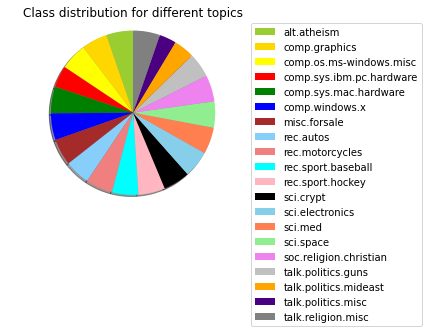

In [6]:
# Visualizing class Distribution
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
# Counter(labels)
label_20, values = zip(*Counter(gnd_labels).items())
indexes = np.arange(len(label_20)) 

# plot the labels
label_20 = dataset.target_names
val = values
colors = ['yellowgreen', 'gold', 'yellow', 'red', 'green', 'blue', 'brown', 'lightskyblue', 'lightcoral','cyan','lightpink','black', 'skyblue', 'coral','lightgreen', 'violet', 'silver', 'orange', 'indigo', 'gray']
patches, texts = plt.pie(val,colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
# plt.legend(patches, labels, loc="best")
plt.legend(patches, label_20, bbox_to_anchor=(0.95,1.025), loc="upper left")
plt.axis('equal')
plt.tight_layout()
plt.title('Class distribution for different topics')
plt.show()

In [7]:
# Let's show the first 2 documents
for i in range(2):
    doc = corpus[i]
    category = dataset.target_names[gnd_labels[i]]
    print("The {}-th sent of {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th sent of rec.sport.baseball: 
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

The 2-th sent of comp.sys.mac.hardware: Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wou

In [1]:
!pip install stop_words

In [2]:
# perform more Pre-processing steps
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from pprint import pprint

def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    for doc in docs:
        raw_text = doc.lower()
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords
        stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
        # remoce digis and one-charcter word
        doc = [token for token in stopped_tokens_text if not token.isnumeric()]
        doc = [token for token in stopped_tokens_text if len(token) > 1]
        # you could always add some new preprocessing here
        yield doc

In [8]:
# Preprocess all the documents in the corpus
Vocab_v1 = list(pre_processing(corpus))

In [9]:
# verify length of the clean corpus and print a sample clean tokenized document
print(len(Vocab_v1))
print(Vocab_v1[0])

18846
['morgan', 'guzman', 'will', "era's", 'run', 'higher', 'last', 'year', 'cubs', 'will', 'idiots', 'pitch', 'harkey', 'much', 'hibbard', 'castillo', 'good', 'think', 'stud', 'pitcher']


In [10]:
from gensim.models import word2vec
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
import time
import pandas as pd

In [12]:
# train the Word2Vec model on the cleaned sentences
start = time.time()
# Set values for various parameters
# Dimensionality of the hidden layer representation
num_features = 100
# Minimum word count to keep a word in the vocabulary    
min_word_count = 20
# Context window size (on each side)
context = 5
# Downsample setting for frequent words                                                             
downsampling = 1e-3  

# Initialize and train the model. 
print("Training model...");
w2v_model = word2vec.Word2Vec(Vocab_v1, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)
# calling init_sims to make the model more memory efficient by normalizing the vectors in-place.
w2v_model.init_sims(replace=True);
# Save the model
model_name = "model_full_20newsGroup";
w2v_model.save(model_name);
print('Total time: ' + str((time.time() - start)) + ' secs')

Training model...
Total time: 6.600787401199341 secs


In [14]:
# Obtain the Word Vectors for each word in the vocab, stored in a variable called ‘syn0’
word_vectors = w2v_model.wv.vectors;
print(word_vectors[0].shape)
# print word vector for the first word: 100-element vector with values
word_vectors[0]

(100,)


array([-0.08109041, -0.11170291, -0.03786368,  0.04577025, -0.1501596 ,
        0.03407255,  0.04241693, -0.05468891, -0.06648247,  0.00713087,
        0.09875803,  0.10026147, -0.13723473,  0.05490759,  0.05868307,
        0.12104908,  0.00375613,  0.10441702,  0.01740058, -0.07892759,
        0.0960447 , -0.00063284,  0.16606937,  0.07305942,  0.1297238 ,
       -0.00252107, -0.07424199,  0.10461033,  0.0063034 ,  0.07568811,
       -0.10179143, -0.09634305,  0.2896279 , -0.14297634, -0.0181797 ,
       -0.09973574, -0.01955063,  0.00366073,  0.16793706,  0.09375884,
       -0.14104366, -0.01075287,  0.00467316,  0.07346121,  0.02225687,
       -0.07903669,  0.05074568,  0.0947161 ,  0.00064641,  0.00737658,
       -0.00344054,  0.13326502,  0.04474064,  0.13863742,  0.18812817,
       -0.04460805,  0.10299973, -0.11345523,  0.06330114,  0.03149972,
       -0.0503973 ,  0.01790727,  0.14311233, -0.10186114,  0.01982173,
       -0.01438802,  0.09877817,  0.3200013 ,  0.15822515,  0.04

In [15]:
# print length of word vectors
len(word_vectors)

11595

In [17]:
# cluster the words using KMeans
num_clusters = 20
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
clusters = kmeans_clustering.fit_predict(word_vectors)
centers = kmeans_clustering.cluster_centers_
centroid_map = dict(zip(w2v_model.wv.index_to_key, clusters))

In [18]:
# get words in each cluster that are closest to the cluster center
# initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center.
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

In [20]:
# get the top words and print the first 2 in each cluster:
top_words = get_top_words(w2v_model.wv.index_to_key, 5000, centers, word_vectors);
top_words[:2]

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19
1,corrections,tigers,rv,regulation,anxiety,twenty,allocate,anymore,freenet,sunlight,speaks,mechanisms,176,melbourne,grandparents,accelerator,screaming,nfs,bulb,difficulty
2,summary,twins,0r,welfare,nonetheless,estimated,parameter,bother,gibson,flowing,gifts,coordinate,429,massachusetts,turkiye,50mhz,wound,x386,drain,inherently


In [21]:
# Create a word cloud with the words of a cluster and print and save them.
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

In [23]:
!pip install wordcloud

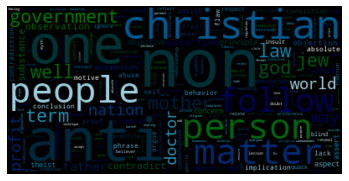

In [24]:
# call on each cluster, and pass in a different color scheme in each iteration to distinguish them.
from wordcloud import WordCloud 
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(0, 20):
    col = next(cmaps)
    display_cloud(i, col)

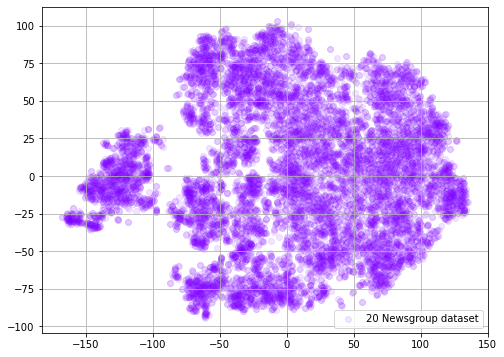

In [27]:
# Visualize learned word embedding space using t-SNE1
from sklearn.manifold import TSNE
import matplotlib.cm as cm
words_20ng = []
embeddings_20ng = []
for word in list(w2v_model.wv.key_to_index):
    embeddings_20ng.append(w2v_model.wv[word])
    words_20ng.append(word)
    
tsne_w2v_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_w2v_2d = tsne_w2v_2d.fit_transform(embeddings_20ng)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(8, 6))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('20 Newsgroup dataset', embeddings_w2v_2d, a=0.1)

In [28]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn import utils
import csv
from tqdm import tqdm

In [29]:
# prepare data for training the doc2vec model
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(Vocab_v1)]

In [33]:
max_epochs = 20
vec_size = 50
alpha = 0.025
# Train the model
d2v_model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)
d2v_model.build_vocab(tagged_data)
# dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW).
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 1960.0461556911469 secs


In [35]:
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    d2v_model.train(tagged_data,
                total_examples=d2v_model.corpus_count,
                epochs=d2v_model.epoch)
    # decrease the learning rate
    d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha

d2v_model.save("d2v.model")
print("Model Saved")

iteration 0


AttributeError: 'Doc2Vec' object has no attribute 'epoch'